# Make Results Figures

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [48]:
architecture = 'fcn2'
branches = 4
shared_frac_list = [0, 0.25, 0.5, 0.75, 1]

## Ensemble

In [49]:
df = pd.read_csv('results/mnist-{}/B{}-test.csv'.format(architecture, branches))

In [50]:
df

,Unnamed: 0,acc_1,acc_2,acc_3,acc_4,after_mean_acc,before_mean_acc,model_id_1,model_id_2,model_id_3,model_id_4
0,0,0.9494,0.9426,0.9540,0.9437,0.9560,0.9565,3,6,4,8
1,0,0.9540,0.9452,0.9481,0.9494,0.9564,0.9561,4,1,5,3
2,0,0.9481,0.9540,0.9437,0.9381,0.9561,0.9563,5,4,8,7
3,0,0.9437,0.9540,0.9420,0.9494,0.9568,0.9568,8,4,2,3
4,0,0.9494,0.9540,0.9381,0.9481,0.9551,0.9550,3,4,7,5
5,0,0.9420,0.9481,0.9426,0.9437,0.9557,0.9563,2,5,6,8
6,0,0.9420,0.9381,0.9481,0.9540,0.9553,0.9557,2,7,5,4
7,0,0.9481,0.9540,0.9420,0.9452,0.9559,0.9560,5,4,2,1


In [51]:
avg_acc = df['before_mean_acc'].mean()
std_acc = df['before_mean_acc'].std()
print(avg_acc, std_acc)

0.9560875 0.0005488624600025195


## Baseline

In [52]:
baseline_val_acc = []
for i in range(8):
    df = pd.read_csv('results/mnist-{}/train_{}.csv'.format(architecture, i+1))
    baseline_val_acc.append(df.iloc[-1]['val_acc'])
baseline = np.mean(baseline_val_acc)
print(baseline)

0.9453874975442886


In [53]:
print(baseline_val_acc)

[0.9452000260353088, 0.9419999718666076, 0.9494000077247621, 0.9539999961853028, 0.948099970817566, 0.9426000118255616, 0.9380999803543092, 0.9437000155448914]


## Virtual Branching

In [54]:
results = {}
results_std = {}
for frac in shared_frac_list:
    val_acc = []
    for i in range(4):
        df = pd.read_csv('results/vb-mnist-{}/B{}/S{:.2f}/train_{}.csv'.format(architecture, branches, frac, i+1))
        val_acc.append(df.iloc[-1]['val_acc_ensemble'])
    print(frac, val_acc)
    results[frac] = np.mean(val_acc)
    results_std[frac] = np.std(val_acc)

0 [0.9588000178337096, 0.9582999944686891, 0.9573000073432922, 0.9581000208854676]
0.25 [0.9563999772071838, 0.9570000171661376, 0.955900013446808, 0.9556000232696532]
0.5 [0.9538999795913696, 0.9549000263214112, 0.9542000293731691, 0.9524999856948853]
0.75 [0.9513999819755554, 0.9570000171661376, 0.9556000232696532, 0.9574999809265136]
1 [0.9541000127792358, 0.9550999999046326, 0.9542999863624572, 0.9541000127792358]


In [55]:
results

{0: 0.9581250101327896,
 0.25: 0.9562250077724457,
 0.5: 0.9538750052452087,
 0.75: 0.955375000834465,
 1: 0.9544000029563904}

## Create Figure

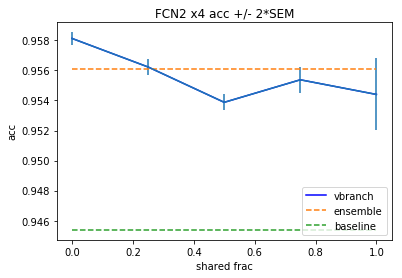

In [60]:
results_list = list(results.items())
results_list.sort()
results_list = np.array(results_list)

plt.plot(results_list[:, 0], results_list[:,1], label='vbranch', color='blue')
trials = 4
error = np.sort(np.array(list(results_std.items())), 0)[:, 1] / np.sqrt(trials)
plt.errorbar(results_list[:, 0], results_list[:,1], error*2)

plt.plot(results_list[:, 0], [avg_acc]*len(results_list), label='ensemble', linestyle='--')
plt.plot(results_list[:, 0], [baseline]*len(results_list), label='baseline', linestyle='--')

# if architecture == 'fcn':
#     plt.ylim(0.94, 0.96)
# else:
#     plt.ylim(0.97, 0.99)

plt.legend(loc='lower right')
plt.xlabel('shared frac')
plt.ylabel('acc')
plt.title('{} x{} acc +/- 2*SEM'.format(architecture.upper(), branches))

plt.savefig('figs/{}-{}-results.png'.format(architecture, branches))
plt.show()

## Model Parameters

In [2]:
import vbranch as vb
from experiments.classification import baseline as baseline_expt
from experiments.classification import vbranch as vb_expt

In [12]:
import tensorflow as tf

num_classes = 10

tf.reset_default_graph()
inputs = tf.placeholder('float32', [None, 784])
labels = tf.placeholder('float32', [None, num_classes])

# Baseline
model = baseline_expt.build_model(architecture, inputs, labels, num_classes,1, test=True)
baseline_params = model.count_parameters()

# Vbranch params
vbranch_params = []
for frac in [0, 0.25, 0.5, 0.75, 1]:
    tf.reset_default_graph()
    
    inputs = tf.placeholder('float32', [None, 784])
    labels = tf.placeholder('float32', [None, num_classes])

    model = vb_expt.build_model(architecture,[inputs]*branches,[labels]*branches, 
                                num_classes, branches, 1, frac, test=True)
    vbranch_params.append(model.count_parameters())

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
param_ratio = [p / baseline_params for p in vbranch_params]
ideal_ratio = branches - np.array(shared_frac_list)**2 * (branches-1)

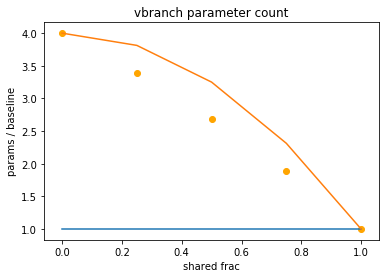

In [18]:
plt.scatter(shared_frac_list, param_ratio, color='orange')
plt.plot(shared_frac_list, [1]*len(shared_frac_list))
plt.plot(shared_frac_list, ideal_ratio)

plt.xlabel('shared frac')
plt.ylabel('params / baseline')
plt.title('vbranch parameter count')

plt.savefig('figs/vbranch-parameter-count.png')
plt.show()